In [ ]:
!pip -q install yfinance arch statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.3/978.3 kB 11.4 MB/s eta 0:00:00


In [ ]:
import warnings; warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model
from scipy import stats
from IPython.display import display

plt.rcParams["figure.figsize"] = (11, 4)
plt.rcParams["axes.grid"] = True
pd.options.display.float_format = lambda x: f"{x:,.6f}"
np.random.seed(123)

In [ ]:
# Puedes cambiar el ticker y el rango de fechas:
TICKER = "AAPL"             # Ejemplos: "SPY", "MSFT", "BTC-USD"
START  = "2019-01-01"
END    = "2025-10-01"

# Descarga de precios (yfinance)
data = yf.download(TICKER, start=START, end=END, progress=False)
px = data["Close"].dropna()

# Retornos logarítmicos en PORCENTAJE (estándar para 'arch')
r = 100*np.log(px/px.shift(1)).dropna()
r.name = "ret_%"

print("▶ Dimensiones")
print("  - Observaciones de precio :", len(px))
print("  - Observaciones de retornos:", len(r))

print("\n▶ Últimos 5 precios y retornos")
display(px.tail())
display(r.tail())

▶ Dimensiones
  - Observaciones de precio : 1696
  - Observaciones de retornos: 1695

▶ Últimos 5 precios y retornos


Ticker,AAPL
Date,
2025-09-24,252.309998
2025-09-25,256.869995
2025-09-26,255.460007
2025-09-29,254.429993
2025-09-30,254.630005


Ticker,AAPL
Date,
2025-09-24,-0.836724
2025-09-25,1.791162
2025-09-26,-0.550423
2025-09-29,-0.404015
2025-09-30,0.078581


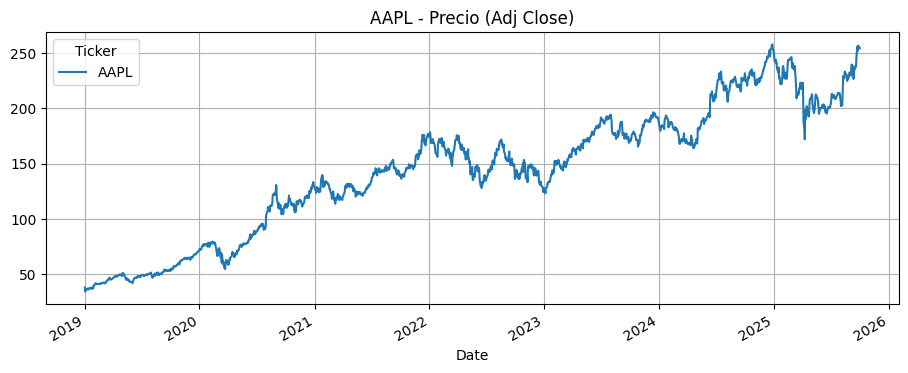

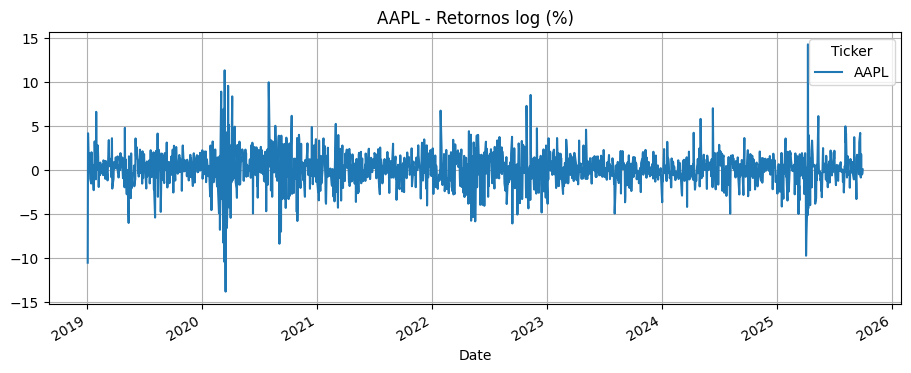

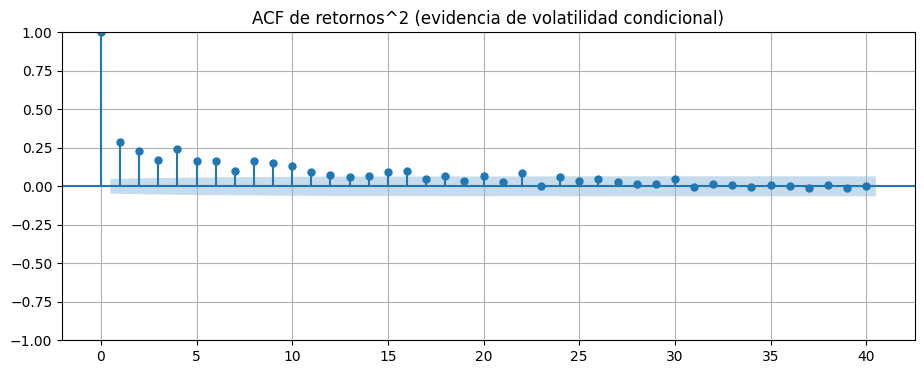

▶ ARCH-LM sobre retornos
{'ARCH-LM stat': np.float64(269.841), 'p-value': np.float64(9.824426038156346e-51)}


In [ ]:
# Precio y retornos
px.plot(title=f"{TICKER} - Precio (Adj Close)")
plt.show()

r.plot(title=f"{TICKER} - Retornos log (%)")
plt.show()

# ACF de retornos^2 (muestra 'clustering' de volatilidad)
plot_acf((r/100.0)**2, lags=40)
plt.title("ACF de retornos^2 (evidencia de volatilidad condicional)")
plt.show()

# ARCH-LM en retornos (p-valor pequeño => hay efectos ARCH)
lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch((r.values/100.0), nlags=12)
print("▶ ARCH-LM sobre retornos")
print({"ARCH-LM stat": round(lm_stat,3), "p-value": lm_pvalue})


In [ ]:
def search_arch_models(r_pct, p_max=6, dists=("normal","t")):
    """Explora ARCH(p) para p=1..p_max y dist en {'normal','t'}, selecciona por BIC."""
    rows = []
    for dist in dists:
        for p in range(1, p_max+1):
            try:
                am = arch_model(r_pct, mean="Zero", vol="ARCH", p=p, dist=dist)
                res = am.fit(disp="off")
                sum_alpha = sum(v for k,v in res.params.items() if k.startswith("alpha["))
                rows.append({
                    "family": "ARCH", "spec": f"ARCH({p})", "p": p, "q": 0, "dist": dist,
                    "loglik": res.loglikelihood, "AIC": res.aic, "BIC": res.bic,
                    "sum_alpha": float(sum_alpha)
                })
            except Exception:
                rows.append({
                    "family": "ARCH", "spec": f"ARCH({p})", "p": p, "q": 0, "dist": dist,
                    "loglik": np.nan, "AIC": np.nan, "BIC": np.nan, "sum_alpha": np.nan
                })
    return (pd.DataFrame(rows)
              .sort_values(["BIC","AIC","p"])
              .reset_index(drop=True))

def search_garch_models(r_pct, p_max=3, q_max=3, dists=("normal","t")):
    """Explora GARCH(p,q) para p=1..p_max, q=1..q_max y dist en {'normal','t'}, selecciona por BIC."""
    rows = []
    for dist in dists:
        for p in range(1, p_max+1):
            for q in range(1, q_max+1):
                try:
                    am = arch_model(r_pct, mean="Zero", vol="GARCH", p=p, q=q, dist=dist)
                    res = am.fit(disp="off")
                    sum_alpha = sum(v for k,v in res.params.items() if k.startswith("alpha["))
                    sum_beta  = sum(v for k,v in res.params.items() if k.startswith("beta["))
                    rows.append({
                        "family": "GARCH", "spec": f"GARCH({p},{q})", "p": p, "q": q, "dist": dist,
                        "loglik": res.loglikelihood, "AIC": res.aic, "BIC": res.bic,
                        "sum_alpha": float(sum_alpha), "sum_beta": float(sum_beta),
                        "alpha+beta": float(sum_alpha + sum_beta)
                    })
                except Exception:
                    rows.append({
                        "family": "GARCH", "spec": f"GARCH({p},{q})", "p": p, "q": q, "dist": dist,
                        "loglik": np.nan, "AIC": np.nan, "BIC": np.nan,
                        "sum_alpha": np.nan, "sum_beta": np.nan, "alpha+beta": np.nan
                    })
    return (pd.DataFrame(rows)
              .sort_values(["BIC","AIC","p","q"])
              .reset_index(drop=True))

def fit_arch_winner(r_pct, row):
    am = arch_model(r_pct, mean="Zero", vol="ARCH", p=int(row["p"]), dist=row["dist"])
    return am.fit(disp="off")

def fit_garch_winner(r_pct, row):
    am = arch_model(r_pct, mean="Zero", vol="GARCH", p=int(row["p"]), q=int(row["q"]), dist=row["dist"])
    return am.fit(disp="off")

def diagnostics(res, title="Modelo"):
    """Diagnóstico corto y visible: p-valores y gráfico de σ_t."""
    resid_std = res.std_resid.dropna()
    lb_r  = acorr_ljungbox(resid_std, lags=[10,20], return_df=True)["lb_pvalue"]
    lb_r2 = acorr_ljungbox((resid_std**2), lags=[10,20], return_df=True)["lb_pvalue"]
    lm_stat, lm_p, _, _ = het_arch(resid_std.values, nlags=12)

    # Tabla diagnóstica amigable
    diag_tbl = pd.DataFrame({
        "Métrica": ["AIC","BIC","LogLik","LB res (lag10) p","LB res (lag20) p","LB res^2 (lag10) p","LB res^2 (lag20) p","ARCH-LM post p"],
        "Valor":  [res.aic, res.bic, res.loglikelihood, lb_r.iloc[0], lb_r.iloc[1], lb_r2.iloc[0], lb_r2.iloc[1], lm_p]
    })
    print(f"\n=== {title}: Resumen & Diagnóstico ===")
    display(diag_tbl)

    # Volatilidad condicional (σ_t en %)
    sig = res.conditional_volatility
    sig.plot(title=f"{title} - Volatilidad condicional (σ_t, %)")
    plt.show()

def stability_flags(res, family):
    """Cálculo de sumas y banderas de estabilidad/persistencia (para reporte)."""
    alphas = sum(v for k,v in res.params.items() if k.startswith("alpha["))
    betas  = sum(v for k,v in res.params.items() if k.startswith("beta["))
    if family=="ARCH":
        return alphas, np.nan, (alphas < 1.0)
    else:
        return alphas, betas, (alphas + betas < 1.0)


In [ ]:
arch_grid  = search_arch_models(r, p_max=6, dists=("normal","t"))
garch_grid = search_garch_models(r, p_max=3, q_max=3, dists=("normal","t"))

print("=== TOP ARCH por BIC ===")
print(arch_grid.head(10).to_string(index=False))

print("=== TOP GARCH por BIC ===")
print(garch_grid.head(10).to_string(index=False))

best_arch_row  = arch_grid.iloc[0]
best_garch_row = garch_grid.iloc[0]

print("\n▶ Selección por BIC")
print("  - Mejor ARCH :", dict(best_arch_row))
print("  - Mejor GARCH:", dict(best_garch_row))

=== TOP ARCH por BIC ===
family    spec  p  q   dist        loglik          AIC          BIC  sum_alpha
  ARCH ARCH(6)  6  0      t -3,327.739365 6,671.478730 6,714.962234   0.593992
  ARCH ARCH(5)  5  0      t -3,332.397833 6,678.795666 6,716.843732   0.561013
  ARCH ARCH(4)  4  0      t -3,337.828662 6,687.657324 6,720.269952   0.520032
  ARCH ARCH(3)  3  0      t -3,347.569267 6,705.138534 6,732.315724   0.466697
  ARCH ARCH(2)  2  0      t -3,354.647585 6,717.295169 6,739.036922   0.399047
  ARCH ARCH(1)  1  0      t -3,368.807218 6,743.614435 6,759.920750   0.275597
  ARCH ARCH(6)  6  0 normal -3,391.598893 6,797.197787 6,835.245853   0.575485
  ARCH ARCH(5)  5  0 normal -3,399.779620 6,811.559239 6,844.171867   0.555738
  ARCH ARCH(4)  4  0 normal -3,406.941858 6,823.883716 6,851.060906   0.535422
  ARCH ARCH(3)  3  0 normal -3,419.590759 6,847.181518 6,868.923271   0.487914
=== TOP GARCH por BIC ===
family       spec  p  q   dist        loglik          AIC          BIC  sum_alph

=== Parámetros Mejor ARCH ===


,estimate
omega,1.627065
alpha[1],0.150527
alpha[2],0.092592
alpha[3],0.056988
alpha[4],0.095615
alpha[5],0.103102
alpha[6],0.095167
nu,4.828189


=== Parámetros Mejor GARCH ===


,estimate
omega,0.139241
alpha[1],0.095871
beta[1],0.868664
nu,5.007759



▶ Estabilidad / Persistencia
  - ARCH: sum(alpha) = 0.5940  | estable(<1): True
  - GARCH: alpha+beta = 0.9645 | estable(<1): True

=== Mejor ARCH(6) (dist=t): Resumen & Diagnóstico ===


,Métrica,Valor
0,AIC,"6,671.478730"
1,BIC,"6,714.962234"
2,LogLik,"-3,327.739365"
3,LB res (lag10) p,0.785323
4,LB res (lag20) p,0.703226
5,LB res^2 (lag10) p,0.857181
6,LB res^2 (lag20) p,0.469017
7,ARCH-LM post p,0.937154


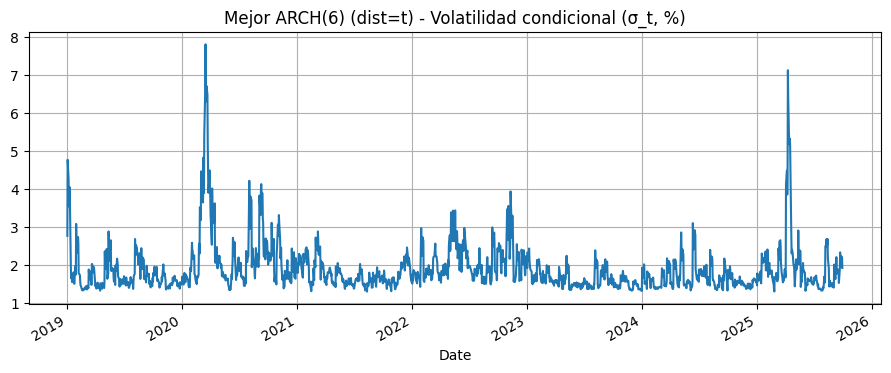


=== Mejor GARCH(1,1) (dist=t): Resumen & Diagnóstico ===


,Métrica,Valor
0,AIC,"6,641.992358"
1,BIC,"6,663.734110"
2,LogLik,"-3,316.996179"
3,LB res (lag10) p,0.681390
4,LB res (lag20) p,0.617591
5,LB res^2 (lag10) p,0.643346
6,LB res^2 (lag20) p,0.784469
7,ARCH-LM post p,0.740605


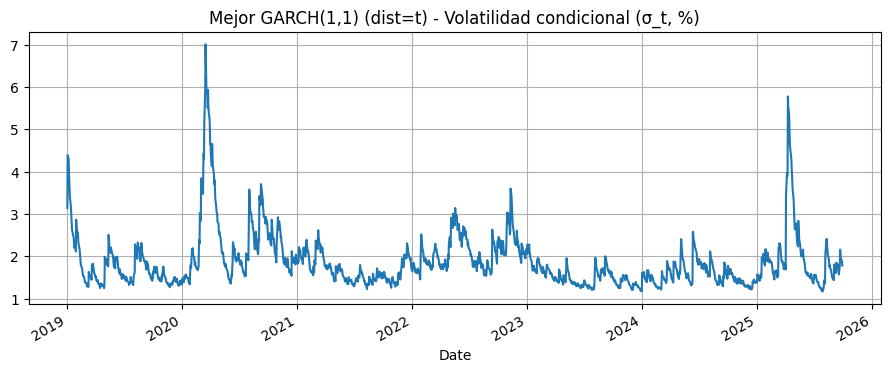

In [ ]:
res_arch_best  = fit_arch_winner(r, best_arch_row)
res_garch_best = fit_garch_winner(r, best_garch_row)

# Parámetros principales (se muestran, no solo se calculan)
print("=== Parámetros Mejor ARCH ===")
display(res_arch_best.params.to_frame("estimate"))

print("=== Parámetros Mejor GARCH ===")
display(res_garch_best.params.to_frame("estimate"))

# Estabilidad (banderas visibles)
a_arch, b_arch, stable_arch = stability_flags(res_arch_best, "ARCH")
a_g, b_g, stable_g = stability_flags(res_garch_best, "GARCH")

print("\n▶ Estabilidad / Persistencia")
print(f"  - ARCH: sum(alpha) = {a_arch:.4f}  | estable(<1): {stable_arch}")
print(f"  - GARCH: alpha+beta = {(a_g + (0 if np.isnan(b_g) else b_g)):.4f} | estable(<1): {stable_g}")

# Diagnósticos con tablas y gráficos
diagnostics(res_arch_best,  f"Mejor {best_arch_row['spec']} (dist={best_arch_row['dist']})")
diagnostics(res_garch_best, f"Mejor {best_garch_row['spec']} (dist={best_garch_row['dist']})")


=== σ pronosticada (próximos 10 pasos, en %) ===
ARCH ganador:


,0,1,2,3,4,5,6,7,8,9
sigma_%,1.441901,1.541516,1.590529,1.546811,1.603695,1.679897,1.763828,1.794149,1.814893,1.833280


GARCH ganador:


,0,1,2,3,4,5,6,7,8,9
sigma_%,1.704067,1.714672,1.724839,1.734589,1.743942,1.752916,1.761529,1.769796,1.777733,1.785356


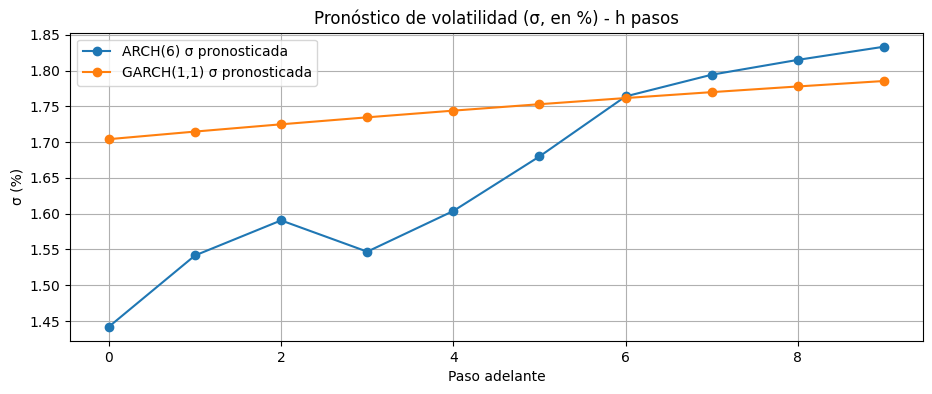

In [ ]:
# Pronóstico de h pasos hacia adelante (en %)
h = 10

def next_sigmas(res, h=10):
    f = res.forecast(horizon=h, reindex=False)
    var_h = f.variance.values[-1]     # varianza en %^2
    return pd.Series(np.sqrt(var_h), name="sigma_%")  # desviación estándar (σ) en %

sig_arch_h  = next_sigmas(res_arch_best,  h)
sig_garch_h = next_sigmas(res_garch_best, h)

print(f"=== σ pronosticada (próximos {h} pasos, en %) ===")
print("ARCH ganador:")
display(sig_arch_h.to_frame().T)  # transpuesta para ver en fila
print("GARCH ganador:")
display(sig_garch_h.to_frame().T)

# Gráfico comparativo de σ pronosticada
plt.plot(sig_arch_h.values, marker="o", label=f"{best_arch_row['spec']} σ pronosticada")
plt.plot(sig_garch_h.values, marker="o", label=f"{best_garch_row['spec']} σ pronosticada")
plt.title("Pronóstico de volatilidad (σ, en %) - h pasos")
plt.xlabel("Paso adelante")
plt.ylabel("σ (%)")
plt.legend()
plt.show()


In [ ]:
# Tabla resumen final visible
final_report = pd.DataFrame({
    "Familia": ["ARCH", "GARCH"],
    "Especificación": [best_arch_row["spec"], best_garch_row["spec"]],
    "Distribución": [best_arch_row["dist"], best_garch_row["dist"]],
    "BIC": [best_arch_row["BIC"], best_garch_row["BIC"]],
    "AIC": [best_arch_row["AIC"], best_garch_row["AIC"]],
    "sum(alpha)": [a_arch, a_g],
    "sum(beta)": [np.nan, b_g],
    "Estable (<1)": [stable_arch, stable_g]
})
print("=== REPORTE FINAL ===")
print(final_report.to_string(index=False))

# Exportar tablas a disco (Colab -> menú Archivos -> Descargar)
arch_grid.to_csv("grid_ARCH.csv", index=False)
garch_grid.to_csv("grid_GARCH.csv", index=False)
final_report.to_csv("reporte_final.csv", index=False)

print("Archivos exportados:")
print("- grid_ARCH.csv")
print("- grid_GARCH.csv")
print("- reporte_final.csv")

=== REPORTE FINAL ===
Familia Especificación Distribución          BIC          AIC  sum(alpha)  sum(beta)  Estable (<1)
   ARCH        ARCH(6)            t 6,714.962234 6,671.478730    0.593992        NaN          True
  GARCH     GARCH(1,1)            t 6,663.734110 6,641.992358    0.095871   0.868664          True
Archivos exportados:
- grid_ARCH.csv
- grid_GARCH.csv
- reporte_final.csv
